<a href="https://colab.research.google.com/github/Parsa-Baniamerian/Activity_Recognition/blob/main/Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import random
import datetime as dt
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

# **Download and Visualize the Data**

In [ ]:
%%capture

# Download the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the Dataset
!unrar x UCF50.rar

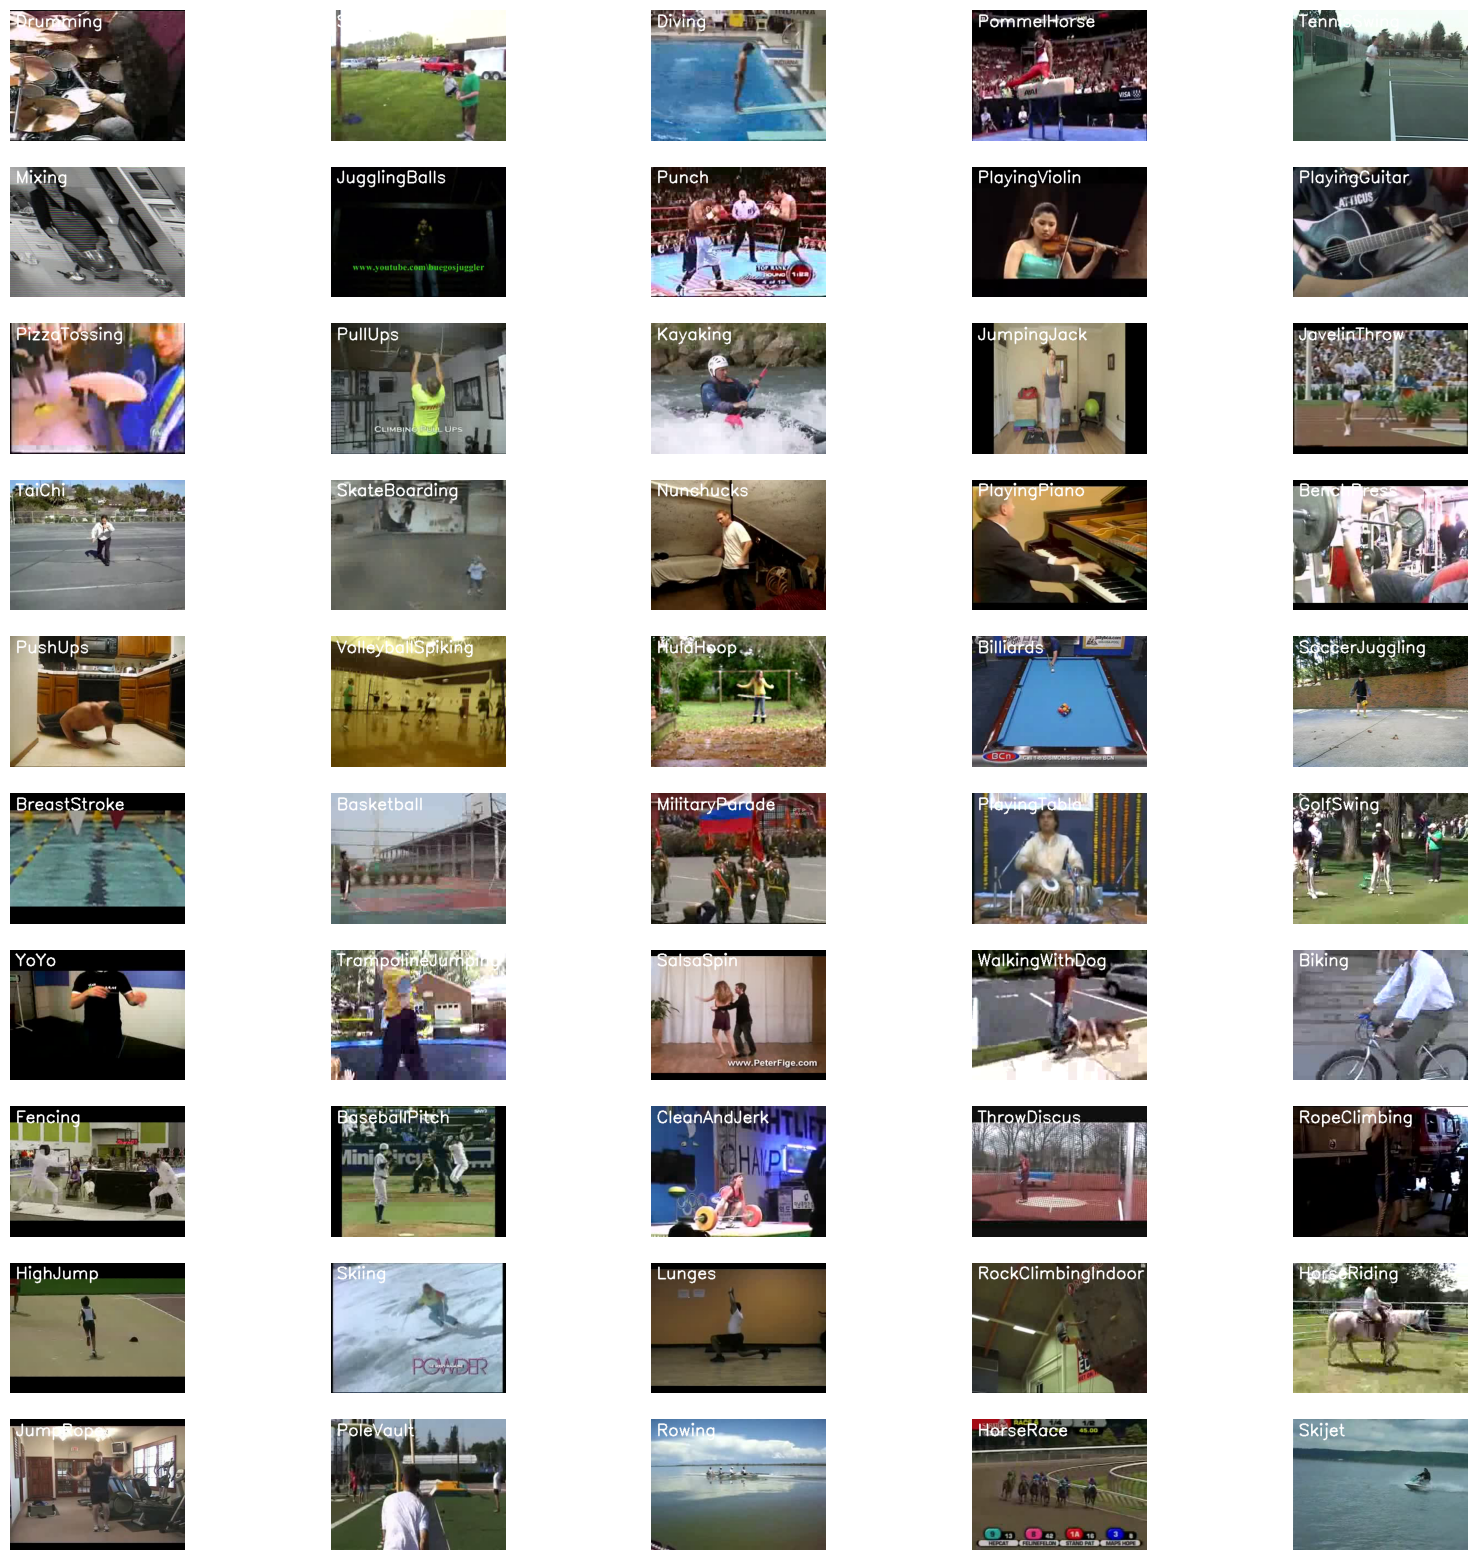

In [ ]:
plt.figure(figsize=(20,20))

all_classes_names = os.listdir("UCF50")

for i in range(len(all_classes_names)):
  selected_class_name = all_classes_names[i]

  # Retrieve the list of the all video files present in selected class directory
  video_files_names_list = os.listdir(f"UCF50/{selected_class_name}")

  # Randomly select a video file the list retrieved from the selected class directory
  selected_video_file_name = random.choice(video_files_names_list)

  # Initialize a VideoCapture object to read from the video files
  video_reader = cv2.VideoCapture(f"UCF50/{selected_class_name}/{selected_video_file_name}")

  # Read the first frame of the video files
  _, bgr_frame = video_reader.read()

  # Release the VideoCapture object
  video_reader.release()

  # Cobvert BGR to RGB
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Write the class name on the video frame
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

  # Display the frame
  plt.subplot(10, 5, i+1)
  plt.imshow(rgb_frame)
  plt.axis("off")

# **Preprocess the Dataset**

In [ ]:
# Specify the height and width to which each video frame will be resized in the dataset
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence
SEQUENCE_LENGTH = 20

DATASET_DIR = "UCF50"
CLASSES_LIST = ["PlayingViolin", "Skiing", "Diving", "Biking"]

In [ ]:
def frame_extraction(video_path):
  """
  This function will extract the required frames from a video after normalizing them.
  Args:
    video_path: The path of the video in the disk, whose frames are to be extracted.
  Returns:
    frames_list: A list containing the resized and normalized frames of the video

  """

  frames_list = []

  video_reader = cv2.VideoCapture(video_path)

  # Get the total number of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculate the interval after which frames will be added to the list
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  # Loop through the video frames
  for frame_counter in range(SEQUENCE_LENGTH):

    # Set the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # Reading frames from the video
    res, frame = video_reader.read()

    # Check if video frame is not successfully read then break the loop
    if not res:
      break

    # Resize the frames to fix height and width
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 , 1
    normalized_frame = resized_frame / 255

    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

In [ ]:
def create_dataset():
  """
  This function will extract the data of the selected classes and create the required dataset.
  Returns:
    features:     A numpy array containing the extracted frames from the videos.
    labels:       A numpy array containing the indexes of the classes associated with the videos.
    Videos_paths: A list containing the paths of the videos in the disk.

  """

  features = []
  labels = []
  videos_paths = []

  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f"Extracting data of class: {class_name}")

    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    for file_name in files_list:
      video_path = os.path.join(DATASET_DIR, class_name, file_name)
      frames = frame_extraction(video_path)

      # Check to ignore the videos having frames less than the SEQUENCE_LENGTH
      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        videos_paths.append(video_path)

  features = np.asarray(features)
  labels = np.array(labels)

  return features, labels, videos_paths

In [ ]:
# Create dataset
features, labels, videos_paths = create_dataset()

# Convert labels into one-hot encoded vectors
one_hot_labels = to_categorical(labels)

# Split data into train and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_labels, test_size=0.25, shuffle=True, random_state=30)

Extracting data of class: PlayingViolin
Extracting data of class: Skiing
Extracting data of class: Diving
Extracting data of class: Biking


# **ConvLSTM model**

In [ ]:
def create_convlstm_model():
  """
  This function will construct the required convlstm model.
  Returns:
    model: It is the required constructed convlstm model.

  """

  model = Sequential()

  model.add(ConvLSTM2D(filters=4, kernel_size=(3,3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding="same", data_format="channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=8, kernel_size=(3,3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding="same", data_format="channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=14, kernel_size=(3,3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding="same", data_format="channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=16, kernel_size=(3,3), activation="tanh", data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2), padding="same", data_format="channels_last"))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST), activation="softmax"))

  model.summary()

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_24 (ConvLSTM2D)          │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_24 (MaxPooling3D)      │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_134                 │ (None, 20, 31, 31, 4)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_25 (ConvLSTM2D)          │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_25 (MaxPooling3D)      │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_135                 │ (None, 20, 15, 15, 8)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_26 (ConvLSTM2D)          │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_26 (MaxPooling3D)      │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_136                 │ (None, 20, 7, 7, 14)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_27 (ConvLSTM2D)          │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_27 (MaxPooling3D)      │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_137                 │ (None, 20, 3, 3, 16)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4)                   │          11,524 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

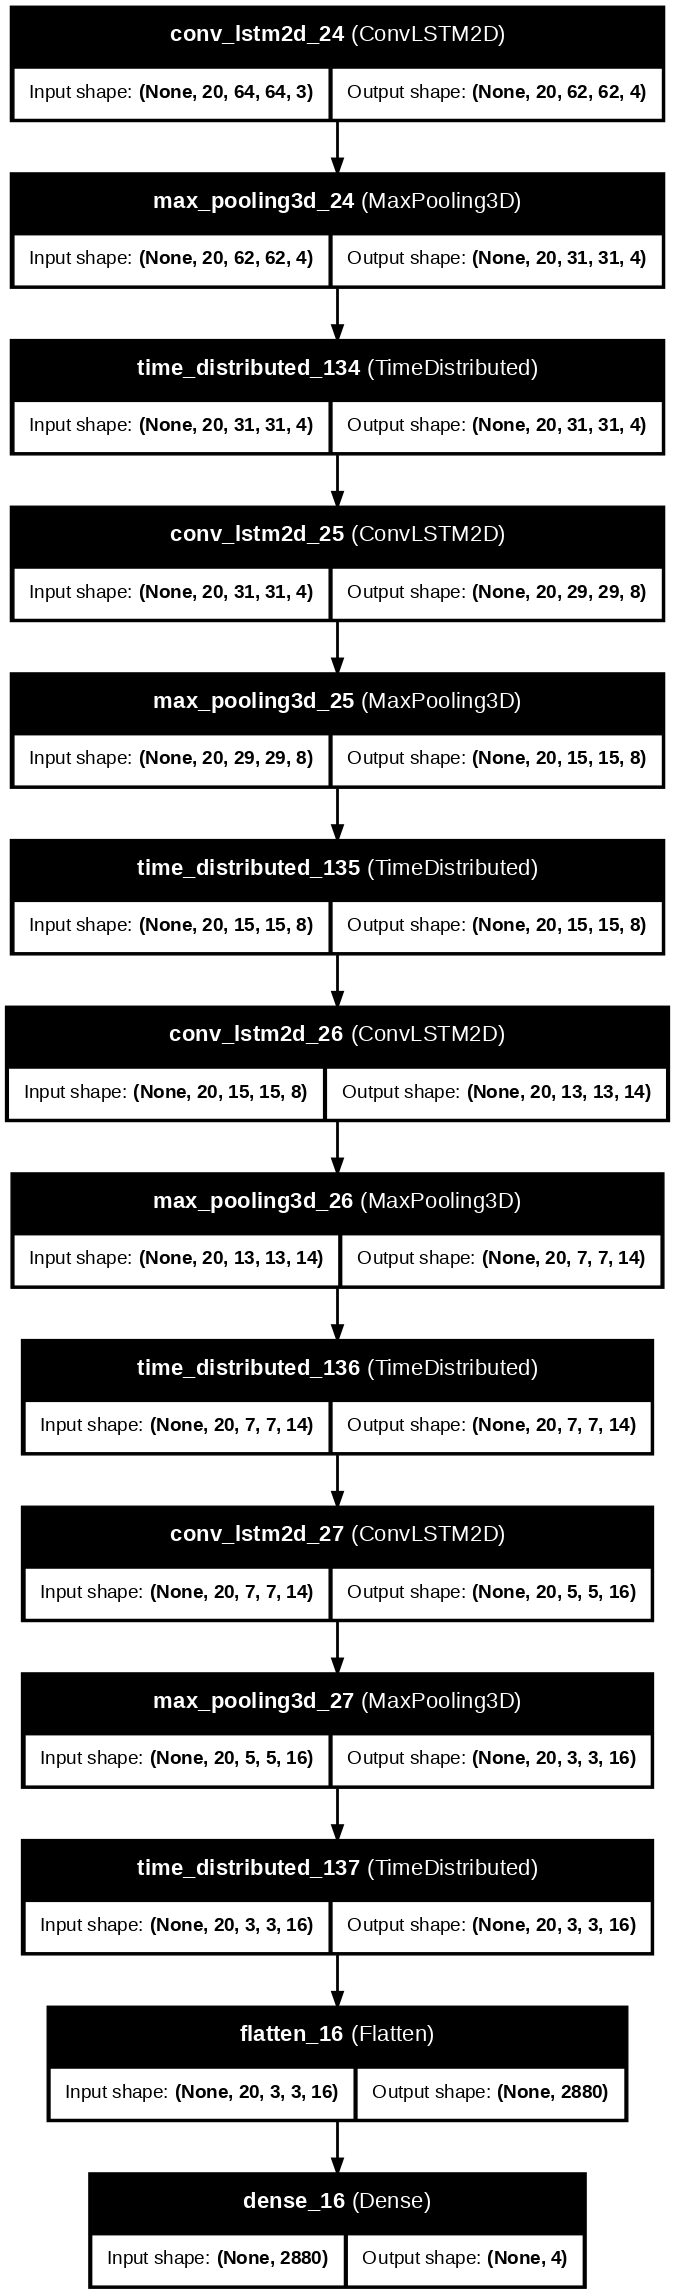

In [ ]:
# Construct ConvLSTM model
convlstm_model = create_convlstm_model()
plot_model(convlstm_model, to_file ="convlstm_model_structure_plot.png", show_shapes=True, show_layer_names=True, dpi=100)

In [ ]:
# Compile and Train the model
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
convlstm_model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

convlstm_model.save("model_convlstm_v1.keras")

Epoch 1/50
81/81 [==============================] - 40s 403ms/step - loss: 1.2428 - accuracy: 0.3611 - val_loss: 1.0089 - val_accuracy: 0.5244
Epoch 2/50
81/81 [==============================] - 31s 387ms/step - loss: 0.9728 - accuracy: 0.5864 - val_loss: 0.7799 - val_accuracy: 0.7073
Epoch 3/50
81/81 [==============================] - 32s 391ms/step - loss: 0.8670 - accuracy: 0.6389 - val_loss: 0.7602 - val_accuracy: 0.6951
Epoch 4/50
81/81 [==============================] - 31s 383ms/step - loss: 0.8218 - accuracy: 0.6759 - val_loss: 0.7400 - val_accuracy: 0.7317
Epoch 5/50
81/81 [==============================] - 32s 392ms/step - loss: 0.6463 - accuracy: 0.7500 - val_loss: 0.9073 - val_accuracy: 0.6585
Epoch 6/50
81/81 [==============================] - 31s 387ms/step - loss: 0.5431 - accuracy: 0.7963 - val_loss: 0.4660 - val_accuracy: 0.8415
Epoch 7/50
81/81 [==============================] - 31s 385ms/step - loss: 0.4242 - accuracy: 0.8333 - val_loss: 0.4724 - val_accuracy: 0.8171

# **Evaluation**

In [ ]:
def plot_metrics(model_training_history, metric1, metric2, plot_title):
  """
  This function will plot the metrics passed to it in a graph.
  Args:
    model_training_history: A history object containing a record of training and validation loss values and metrics values at successive epochs
    metric1:               The first metric that needs to be plotted in the graph.
    metric2:               The second metric that needs to be plotted in the graph.
    plot_title:             The title of the graph.

  """

  # Get metric values
  metric1_value = model_training_history.history[metric1]
  metric2_value = model_training_history.history[metric2]

  epochs = range(len(metric1_value)) # A range object which be used as x-axis of the graph

  plt.plot(epochs, metric1_value, "blue", label=metric1)
  plt.plot(epochs, metric2_value, "red", label=metric2)

  plt.title(str(plot_title))
  plt.legend()

In [ ]:
# Evaluate the trained model
convlstm_model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

5/5 [==============================] - 1s 201ms/step - loss: 0.2996 - accuracy: 0.9265


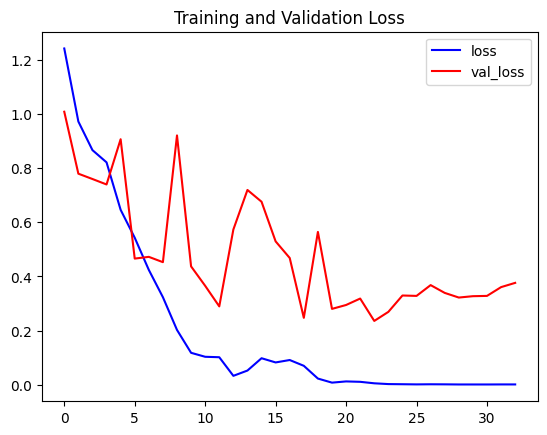

In [ ]:
# Plot the training and validation loss
plot_metrics(convlstm_model_training_history, "loss", "val_loss", "Training and Validation Loss")

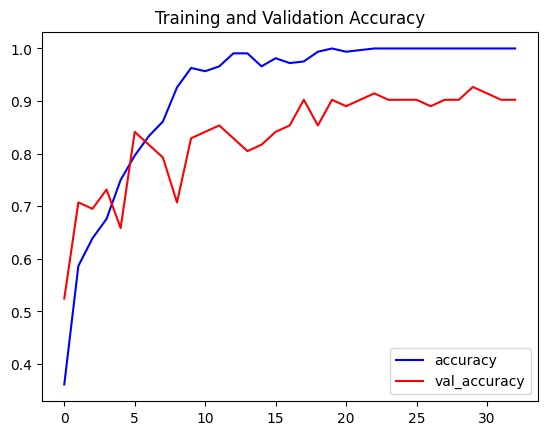

In [ ]:
# Plot the training and validation accuracy
plot_metrics(convlstm_model_training_history, "accuracy", "val_accuracy", "Training and Validation Accuracy")

# **LRCN model**

In [ ]:
def create_lrcn_model():
  """
  This function will construct the required LRCN model.
  Returns:
    model: It is the required constructed LRCN model.

  """

  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3,3), padding="same", activation="relu"), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3,3), padding="same", activation="relu")))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding="same", activation="relu")))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding="same", activation="relu")))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  #model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dense(len(CLASSES_LIST), activation="softmax"))

  model.summary()

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_138                 │ (None, 20, 64, 64, 16)      │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_139                 │ (None, 20, 16, 16, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_140                 │ (None, 20, 16, 16, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_141                 │ (None, 20, 16, 16, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_142                 │ (None, 20, 4, 4, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_143                 │ (None, 20, 4, 4, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_144                 │ (None, 20, 4, 4, 64)        │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_145                 │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_146                 │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_147                 │ (None, 20, 2, 2, 64)        │          36,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_148                 │ (None, 20, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_149                 │ (None, 20, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

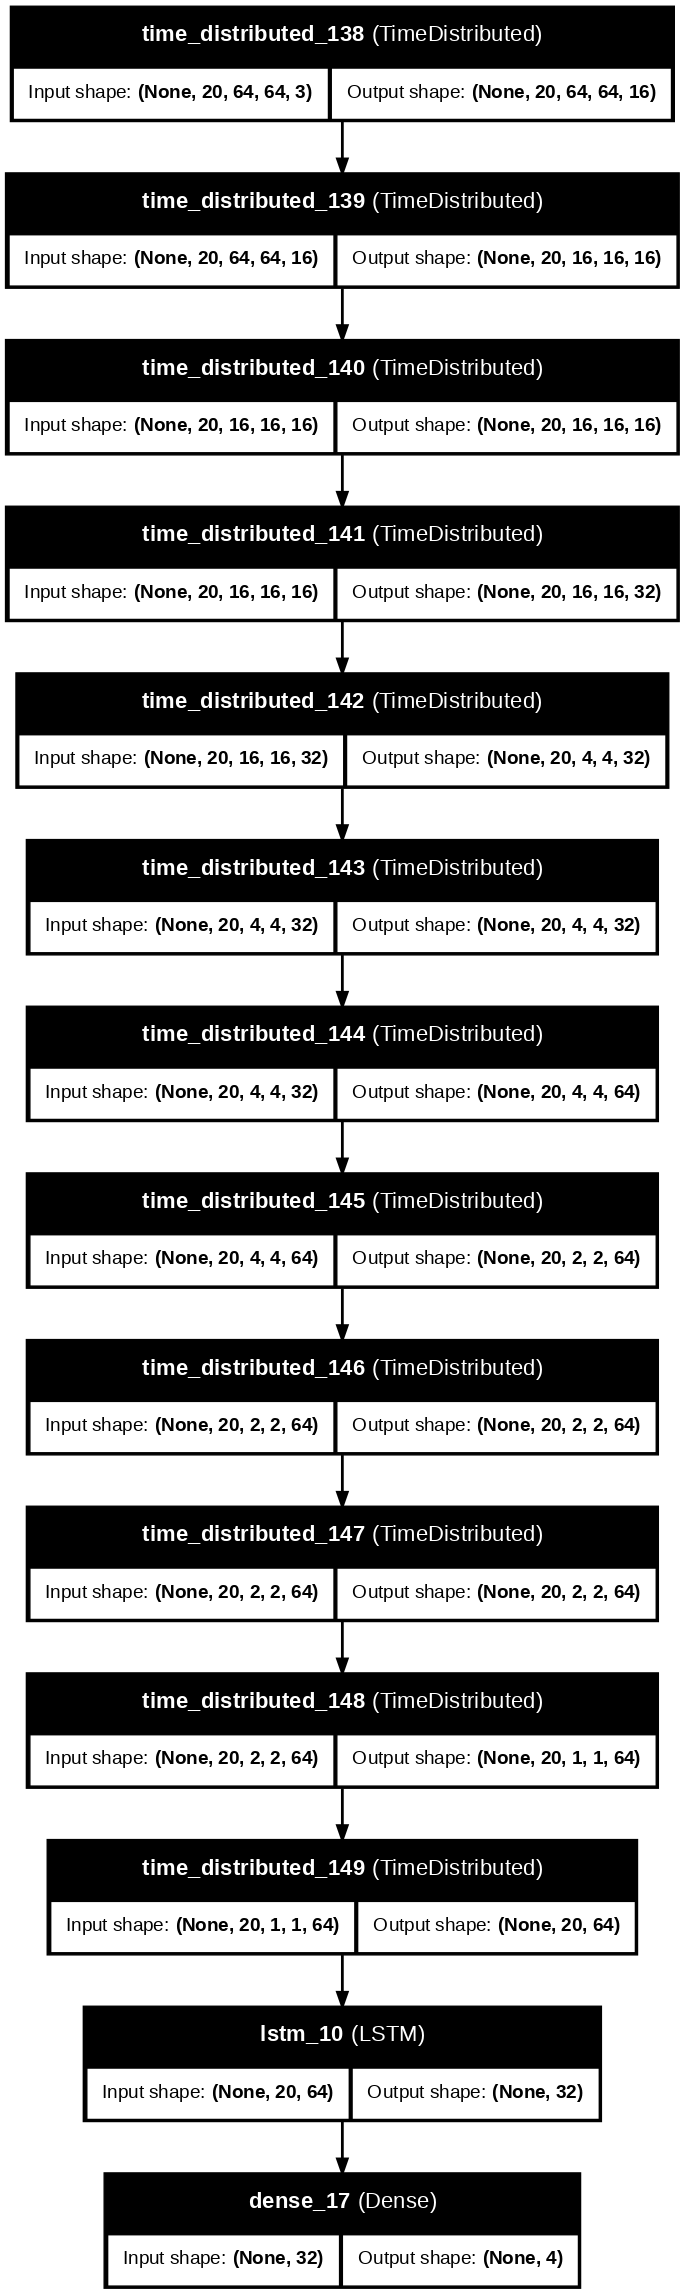

In [ ]:
# Construct LRCN model
lrcn_model = create_lrcn_model()
plot_model(lrcn_model, to_file="LRCN_model_structure_plot.png", show_shapes=True, show_layer_names=True, dpi=100)